## Laboration i Maskininlärning: Sjukdomsprediktion

I denna rapport analyseras, behandlas och används data över patienter för att förutsäga om en patient har hjärt-kärlsjukdom. Features såsom ålder, längd, kolesterolvärden och om patienten röker eller inte, används för maskininlärningsmodeller för att försöka klassa patienten som sjuk eller frisk. Målet är att ta reda på vilken modell som presterar bäst, samt att utvärdera om någon modell är tillräckligt pålitlig i detta sammanhang.

Följande formler och tabeller användes i denna undersökning:

$$BMI = \frac{\text{vikt (kg)}}{\text{längd} \times \text{längd (m)}^2}$$

<br>

| Blood Pressure Category | Systolic (mm Hg) | Diastolic (mm Hg) |
|--------------|-----------|------------|
| Healthy | less than 120 | and less than 80 |
| Elevated | 120-129 | and less than 80 |
| Stage 1 hypertension | 130-139  | or 80-89 |
| Stage 2 hypertension | 140 or higher  | or 90 or higher |
| Hypertension crisis | over 180  | or over 120 |

<br>

| BMI Category | BMI |
|--------------|-----------|
| Normal range | 18,5 – 24,9 |
| Over-weight | 25,0 – 29,9 |
| Obese (class I) | 30,0 – 34,9  |
| Obese (class II) | 35,0 – 39,9 |
| Obese (class III) | More than 40 |

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import plot_cardio_distribution, plot_cholesterol_distribution, plot_smoking_pie, calculate_bmi, get_bmi_category, get_blood_pressure_category, print_suggestions_for_lower_upper_limit, plot_cardio_risk_by_category, plot_gender_cardio_distribution, show_boxplot_for_features, show_histplot_for_features, evaluate_model

df = pd.read_csv('cardio_train.csv', sep=';', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


Informationen ovan visade att samtliga kolumner innehåller värden för alla rader i dataframen. Detta betyder att inga rader eller kolumner initiellt tas bort. Datatyperna för alla kolumner är korrekta, och datasetet framstår vid en första granskning som välstrukturerat.

---

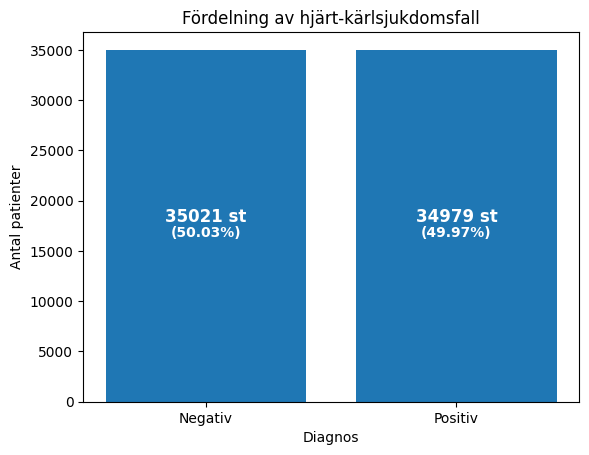

In [2]:
plot_cardio_distribution(df)

Datasetet uppvisar en jämn fördelning mellan patienter med och utan diagnostiserad hjärt-kärlsjukdom, vilket säkerställer att maskininlärningsmodellen tränas på en rättvis representation av båda klasserna och inte favoriserar den vanligaste.

---

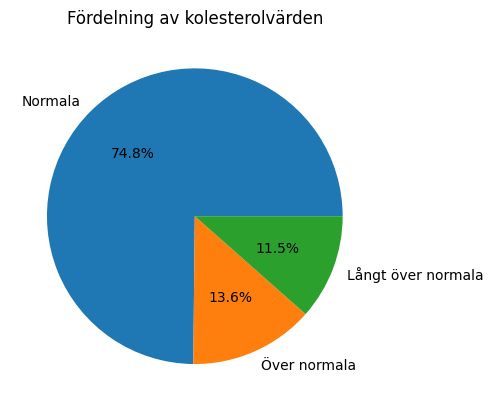

In [3]:
plot_cholesterol_distribution(df)

Fördelningen av kolesterolvärden och nivåerna framstår som rimliga. Det är förväntat att en majoritet har normala värden och att färre har över normala. Huruvida denna fördelning speglar den för populationen är dock svårt att avgöra. Möjligen kan andelen på 11,5% med långt över normala kolesterolvärden uppfattas hög.

---

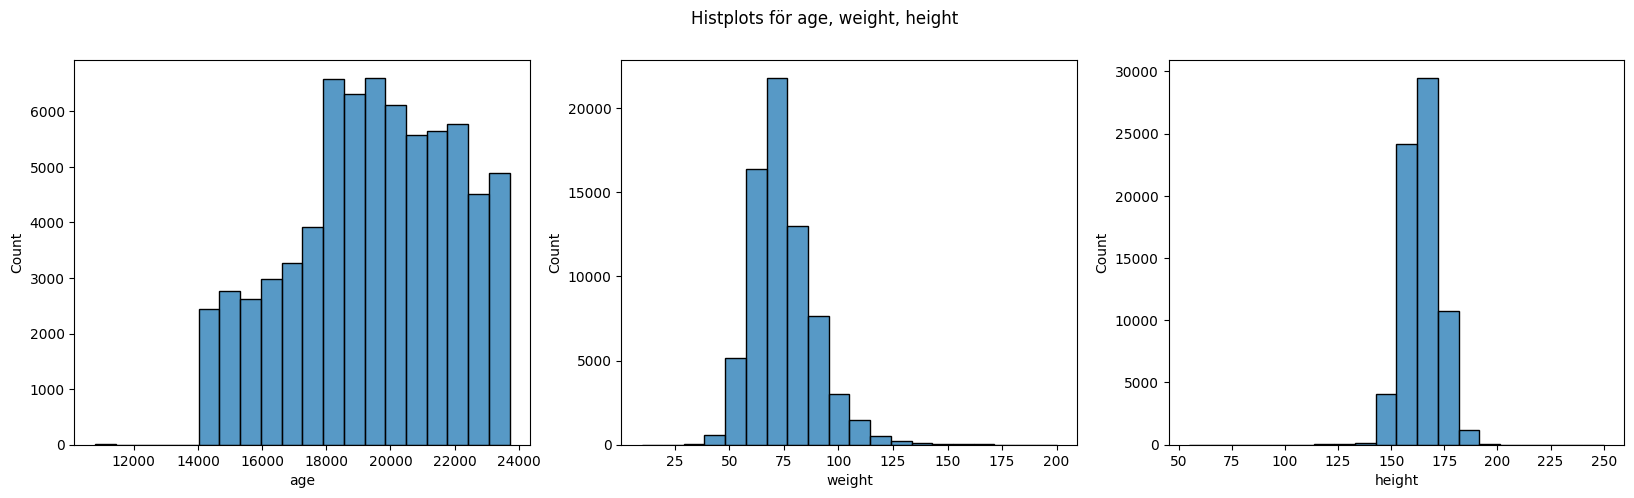

In [4]:
show_histplot_for_features(df, ['age', 'weight', 'height'])

In [5]:
df[['age', 'weight', 'height']].describe()

,age,weight,height
count,70000.000000,70000.000000,70000.000000
mean,19468.865814,74.205690,164.359229
std,2467.251667,14.395757,8.210126
min,10798.000000,10.000000,55.000000
25%,17664.000000,65.000000,159.000000
50%,19703.000000,72.000000,165.000000
75%,21327.000000,82.000000,170.000000
max,23713.000000,200.000000,250.000000


Fördelningen av ålder, vikt och längd framstår överlag som rimlig. Dock förekommer enstaka patienter med avsevärt lägre ålder än övriga. För vikten och höjden är spridningen ganska stor och det förekommer en del outliers.

---

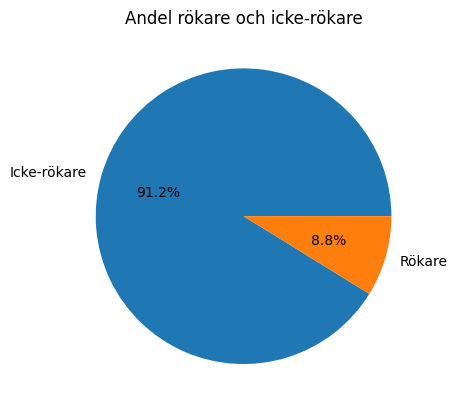

In [6]:
plot_smoking_pie(df)

Att andelen icke-rökare är större än andelen rökare är rimligt. Däremot är andelen rökare på 8,8% relativt låg jämfört med källor på webben över populationen. Enligt tabellen på World Population Review har de flesta länderna en högre andel rökare än vad detta dataset har.
https://worldpopulationreview.com/country-rankings/smoking-rates-by-country

Eftersom icke-rökare utgör majoritet, och det finns en viss andel rökare, kan denna födelning anses vara acceptabel.

---

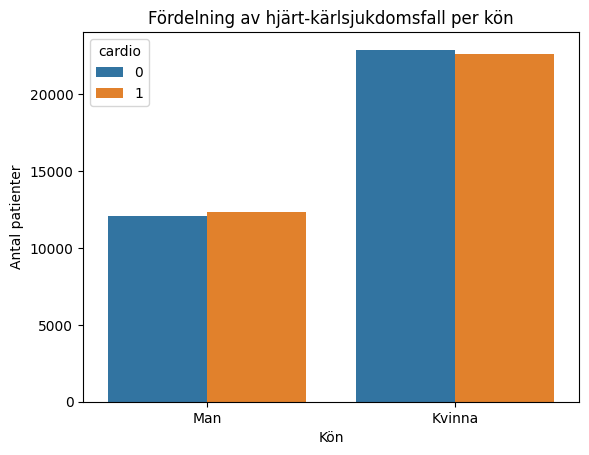

In [7]:
plot_gender_cardio_distribution(df)

Diagrammet visade att andelen kvinnor är större än andelen män i detta dataset. För båda könen är fördelningen mellan de med och utan hjärt-kärlsjukdom relativt jämn. I detta specifika dataset är det fler män med sjukdomen än utan, medan det är fler kvinnor utan sjukdomen än med. Dessa skillnader är dock så pass små att det inte går att dra några slutsatser från dem.

--- 
I datasetet fanns kolumner för vikt och höjd. Dessa användes för att räkna ut BMI för varje patient:

In [8]:
df['bmi'] = calculate_bmi(df['weight'], df['height'] / 100)

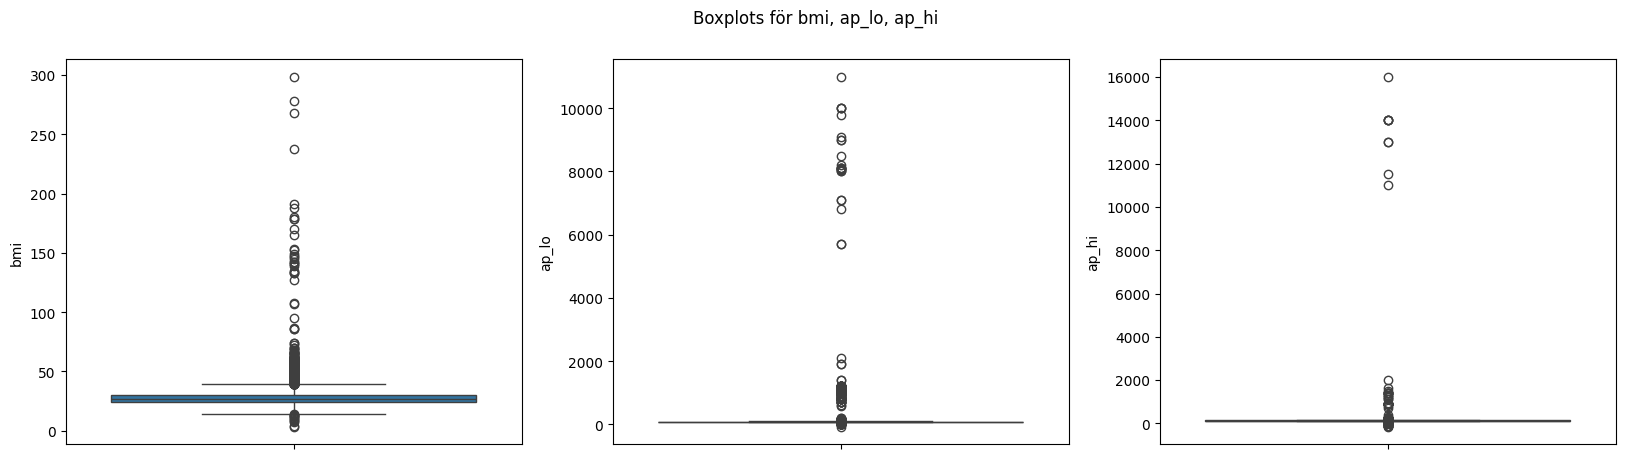

In [9]:
show_boxplot_for_features(df, ['bmi', 'ap_lo', 'ap_hi'])

Datasetet innehåller många felaktigheter, och orimligt höga eller låga värden på en del features. Som visas i boxplot för kolumnerna __bmi__, __ap_lo__ och __ap_hi__, finns det många outliers. För att maskininlärningsmodellen inte ska lära sig av felaktiga värden tas dessa bort. Var dessa gränser sätts är däremot inte uppenbart.

En funktion användes för att få förslag på lägsta och högsta värde som tillåts, för identifiera vilka värden som räknas som outliers:

In [10]:
print_suggestions_for_lower_upper_limit(df, 'bmi')

Förslag på gränser för kolumn: bmi

                     Lägsta gräns  Högsta gräns
Z-score                  9.281979     45.831046
Interquartile range     14.354454     39.742883
Percentile              18.611496     44.425934


In [11]:
print_suggestions_for_lower_upper_limit(df, 'ap_lo')

Förslag på gränser för kolumn: ap_lo

                     Lägsta gräns  Högsta gräns
Z-score               -468.787177    662.048005
Interquartile range     65.000000    105.000000
Percentile              60.000000   1000.000000


In [12]:
print_suggestions_for_lower_upper_limit(df, 'ap_hi')

Förslag på gränser för kolumn: ap_hi

                     Lägsta gräns  Högsta gräns
Z-score               -333.216973    590.851544
Interquartile range     90.000000    170.000000
Percentile              90.000000    180.000000


Tre olika metoder användes för att få förslag på gränsvärden. Värdena från de olika metoderna skilde sig mycket åt, vilket visade att det var bättre att manuellt sätta dessa gränser. Trots detta gav dessa värden en god indikation på spridningen, och särkilt värdena med Interquartile range-metoden visade sig vara användbara för att komma fram till de gränser som skulle användas.

Gränserna för BMI och blodtryck valdes utifrån de förslag som genererades av funktionen samt värdena i tabeller för respektive kategorisering. Att bestämma dessa gränser är svårt och det finns inget sätt som är helt korrekt. En alltför snäv avgränsning kan riskera att exkludera patienter med korrekta mätvärden, medan en tillåtande inkludering av outliers kan riskera att modellen tränas på felaktiga mätvärden.

I detta fall valdes gränser som tillät marginal till de lägsta och högsta värdena i respektive kategorisering. Dessa gränser täcker dock inte alla möjliga verkliga värden, vilket kan medföra att maskininlärningsmodellen presterar sämre för patienter som till exempel har ett BMI-värde som i denna undersökning klassas som en outlier.

Följande gränser valdes för features:

| Feature | Lägsta gräns | Högsta gräns |
|--------------|-----------|----------|
| bmi | 14 | 45 |
| ap_lo | 60 | 130 |
| ap_hi | 90 | 190 |

In [13]:
df = df.query('bmi >= 14 and bmi <= 45')
df = df.query('ap_lo >= 60 and ap_lo <= 130')
df = df.query('ap_hi >= 90 and ap_hi <= 190')

---

Tabeller för blodtryckskategorier och BMI-kategorier används för att tilldela en kategori för båda dessa till varje patient i datasetet:

In [14]:
df['bmi_category'] = df['bmi'].apply(get_bmi_category)
df['ap_category'] = df.apply(lambda row: get_blood_pressure_category(row['ap_hi'], row['ap_lo']), axis=1)

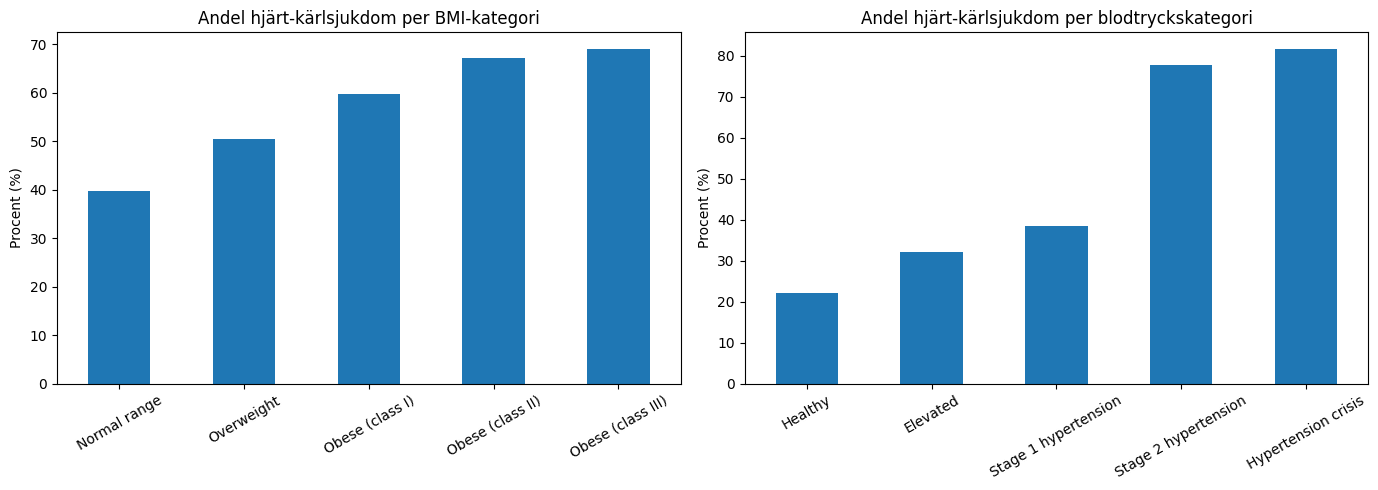

In [15]:
plot_cardio_risk_by_category(df)

Diagrammet ovan visade att både högt BMI och högt blodtryck verkar öka risken för hjärt-kärlsjukdom. Sambandet är särskilt tydligt för blodtryck, där en stor andel av patienterna i de två högsta nivåerna har en diagnotiserad hjärt-kärlsjukdom.

---

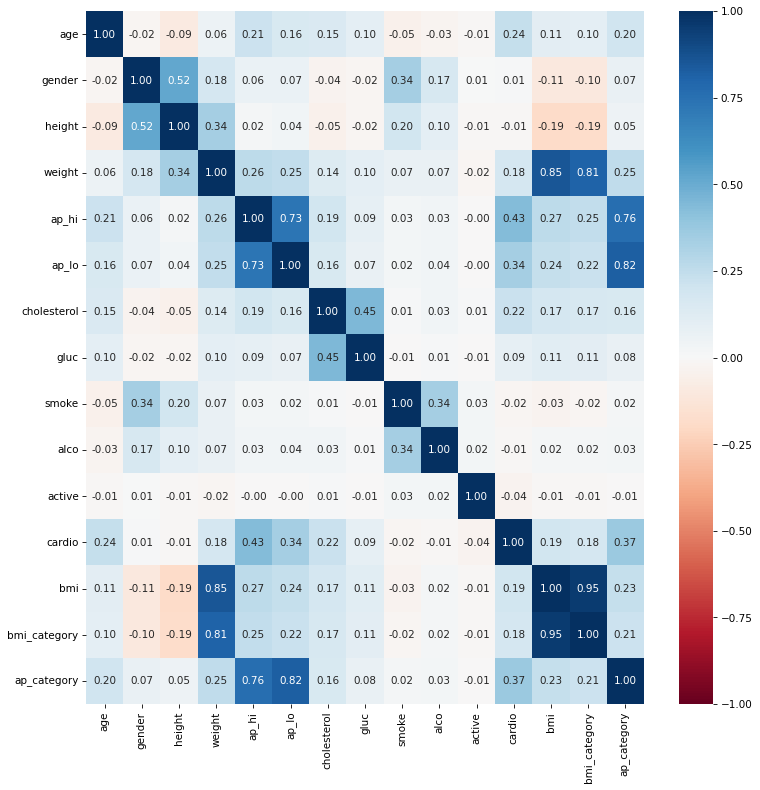

In [16]:
plt.figure(figsize=(12, 12), dpi=75)
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='RdBu')
plt.show()

Som heatmapen visade finns en del korrelationer mellan olika features. Att __ap_hi__ och __ap_lo__ är korrelerade med varandra samt med __ap_category__ är förväntat, då alla dessa är relaterade till blodtryck. En liknande korrelation finns mellan __bmi__, __bmi_category__, __height__ och __weight__, då dessa är länkade genom hur BMI beräknas, samt kategori-indelningen.

En liten korrelation mellan __gender__ och __height__ finns, vilket kan förklaras med att män generellt har ett högre genomsnitt för längd än kvinnor.

När det kommer till __cardio__, är den största korrelationen med blodtrycks-variablerna, vilket stärker sambandet i tidigare diagram.

---

Datasetet delades upp i två separata dataframes. Den ena innehåller de kategoriska features som skapats för BMI och blodtryck, medan värdena för BMI och blodtryck tas bort. Detta dataset kallades för __Categorized features__.

Den andra dataframen innehåller värdena för BMI och blodtryck, och kategorierna tas bort. Detta dataset kallades för __Raw features__.

För att uppnå bästa möjliga prestanda i modellerna ska korrelationer mellan features undvikas. Därför används inte BMI-värden och blodtryck som features tillsammans med deras respektive kategoriseringar. __height__ och __weight__ tas även bort, då dessa redan beaktas i beräkningen av BMI-värdet.

In [17]:
df_copy = df.copy()

df_categorized_features  = df.drop(columns=['ap_hi', 'ap_lo', 'height', 'weight', 'bmi'])
df_categorized_features  = pd.get_dummies(df_categorized_features , columns=['bmi_category', 'ap_category', 'gender'])

df_raw_features = df_copy.drop(columns=['bmi_category', 'ap_category', 'height', 'weight'])
df_raw_features = pd.get_dummies(df_raw_features, columns=['gender'])

---

__Random Forest__, __Logistisk Regression__ och __KNN__ valdes som modeller för denna undersökning. Dessa modeller användes som estimatorer i GridSearchCV, tillsammans med respektive hyperparametrar. Denna returnerade de bästa parametrarna, samt en score för varje modell. I ett senare skede jämfördes modellernas scores för att avgöra vilken modell och vilken dataframe som gav bäst resultat. För scoring av modeller användes __recall__. False Negatives var det som skulle undvikas, då patienter inte ska klassas som friska om de är sjuka.

In [18]:
from ModelTester import ModelTester

model_tester_categorized_features = ModelTester()
model_tester_categorized_features.prepare_data(X=df_categorized_features.drop('cardio', axis=1), y=df_categorized_features['cardio'])

model_tester_raw_features = ModelTester()
model_tester_raw_features.prepare_data(X=df_raw_features.drop('cardio', axis=1), y=df_raw_features['cardio'])

In [19]:
trained_models_categorized_features = model_tester_categorized_features.train_and_optimize()

Tränar RandomForestClassifier...
Bästa hyperparametrar för RandomForestClassifier: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 150}
Tränar LogisticRegression...
Bästa hyperparametrar för LogisticRegression: {'C': 10, 'solver': 'liblinear'}
Tränar KNeighborsClassifier...
Bästa hyperparametrar för KNeighborsClassifier: {'leaf_size': 20, 'n_neighbors': 11, 'weights': 'uniform'}


In [20]:
trained_models_raw_features = model_tester_raw_features.train_and_optimize()

Tränar RandomForestClassifier...
Bästa hyperparametrar för RandomForestClassifier: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 150}
Tränar LogisticRegression...
Bästa hyperparametrar för LogisticRegression: {'C': 0.5, 'solver': 'liblinear'}
Tränar KNeighborsClassifier...
Bästa hyperparametrar för KNeighborsClassifier: {'leaf_size': 20, 'n_neighbors': 11, 'weights': 'uniform'}


In [21]:
model_tester_categorized_features.use_voting_classifier()
model_tester_raw_features.use_voting_classifier()

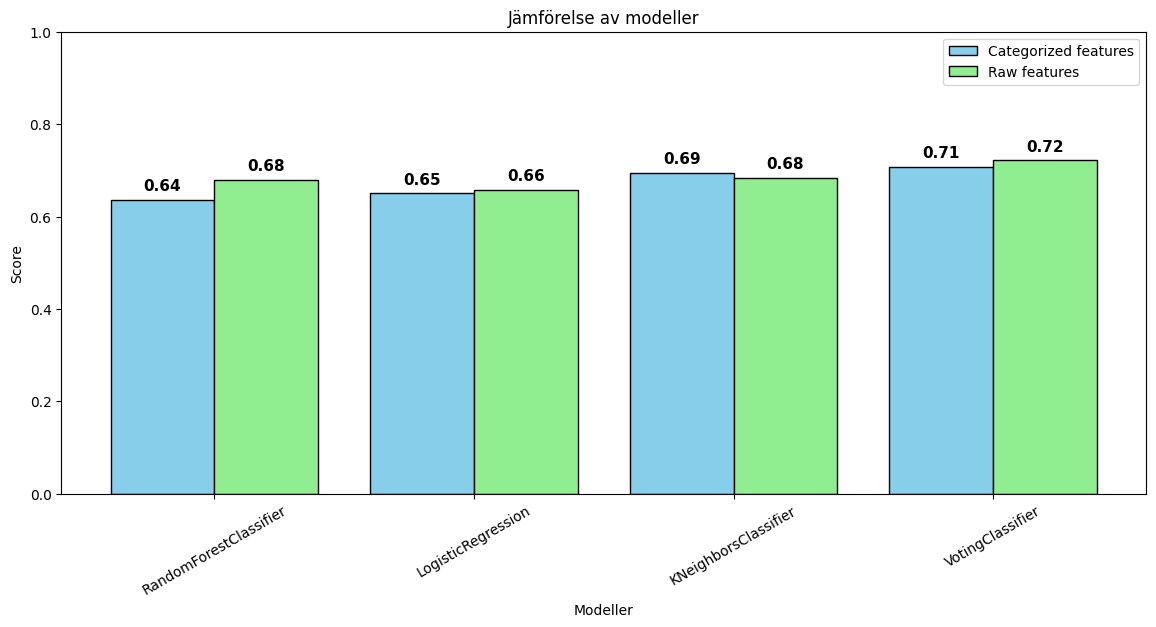

In [22]:
model_tester_categorized_features.plot_model_comparison(model_tester_raw_features, dataset_labels=['Categorized features', 'Raw features'])

Ovan visas scores för de olika modellerna samt för båda dataset. De tre modellerna testades samt ensemble learning gjordes för de båda dataseten. Score för de olika klassificerarna varierade en del mellan olika körningar. __KNN__ var den modell som mest regelbundet gav bäst score av de tre modellerna. Vid ensemble learning med __VotingClassifier__ upptäcktes att denna gav bättre score. Det blev alltså bättre resultat när de tre modellerna kombinerades. Valet av dataset var komplicerat då de kunde variera mellan vilket som fungerade bäst med __VotingClassifier__. Datasetet som kallas __Raw features__, som innehåller kolumnerna __bmi__, __ap_lo__ och __ap_hi__, och alltså inte de kategoriserade kolumnerna, var det som tillslut valdes. Detta eftersom den oftast presterade bäst över alla modeller, och då även __VotingClassifier__.

---

__VotingClassifier__ har valts som modell, och dataset med så kallade "raw features" valdes. Denna modell tränades sedan på all data förutom testdatan, för att sedan evaluera den.

              precision    recall  f1-score   support

           0       0.72      0.78      0.74      3450
           1       0.74      0.68      0.71      3328

    accuracy                           0.73      6778
   macro avg       0.73      0.73      0.73      6778
weighted avg       0.73      0.73      0.73      6778



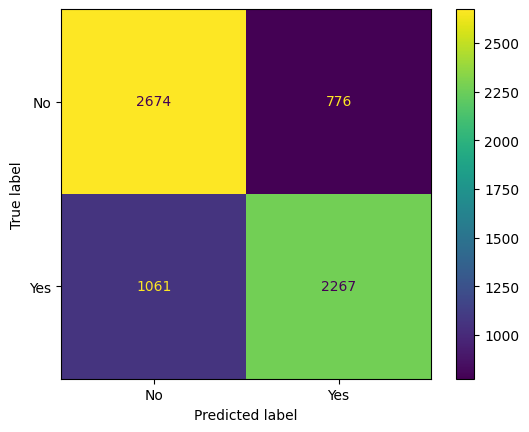

In [23]:
chosen_model_tester = model_tester_raw_features
chosen_model = chosen_model_tester.trained_models['VotingClassifier']['best_estimator']

# Add the validation data to the train data
chosen_model_tester.combine_train_val_data()

X_train, X_test, y_train, y_test = chosen_model_tester.X_train, chosen_model_tester.X_test, chosen_model_tester.y_train, chosen_model_tester.y_test
evaluate_model(chosen_model, X_train, X_test, y_train, y_test)

Vid utvärdering av resultatet av modellen med confusion matrix och classification report, visade detta att modellen kanske inte är tillräckligt bra. Det blev en alldeles för stor andel False Negatives, vilket var det som skulle undvikas. Modellen är inte pålitlig och tillräckligt bra för att använda. Även om en precision och recall runt 0,7 eller 0,75 kunde se okej ut i första anblick, är det inget som är tillräckligt när det gäller att klassa patienter som sjuka eller friska, speciellt när andel False Negatives är såpass stor.

---

Det finns olika sätt denna undersökning kan tas vidare. Eftersom scores för de olika modellerna varierade en del, kan detta vara en indikation på stor varians i datasetet. Vid en stor varians kan det påverka mycket hur datasetet splittas upp i träning och test. I denna undersökning filtrerades bara datasetet på gränserna för BMI och blodtryck. Men det kan möjligtvis finnas andra features som har felaktiga värden och alltför stor spridning. Ett annat sätt man kan fortsätta är att undersöka om det finns features som är irrelevanta och som inte hjälper till att förutspå hjärt-kärlsjukdom. Detta kan vara något att undersöka vidare för att få bättre förutsägelser och bättre modell.

Även valet av gränserna för BMI och blodtrycken påverkar score på modellerna. Andra gränsvärden för dessa hade kunnat påverka både vilken modell som fungerade bäst, men även vilket dataset som presterar mest.

Utöver dessa punkter finns det även maskininlärningsmodeller som inte användes i denna undersökning, och även andra hyperparameter kan användas (param_grids) för modellerna, för att möjligtvis hitta kombinationer av parametrar som fungerar bättre.